In [1]:
import sys
import os
sys.path.append(os.path.abspath('../src')) # include top level package in python path

In [2]:
from IPython.display import display, HTML
display(HTML("""
<style>
.container { 
    width: 100% !important;
}
</style>
"""))

In [3]:
import torch
from torch import nn, Tensor
from model.fuzzy_layer import FuzzyUnsignedConjunction, FuzzyUnsignedDisjunction, FuzzyNumKeepup, keepidx, fuzzy_dropup
from model.fuzzy_logic import ProductLogic, MinimumLogic, LukasiewiczLogic, DrasticLogic, SchweizerSklarLogic
from model.fuzzy_layer import FuzzyParam, FuzzyLoss
from model.bool_logic import BoolLogic
from cache import TrainingRegime, TestMetric
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from util import shuffle

logic = BoolLogic()
flogic = ProductLogic()

In [4]:
device = 'cuda'

In [5]:
def true_conjunction(weights, xs):
    return logic.conjoin(logic.implies(weights, xs), dim=1)

In [6]:
from torch.utils.data import Dataset, DataLoader, RandomSampler

class WeightedDataset(Dataset):
    def __init__(self, N, D, K):
        super().__init__()
        self.samples = torch.zeros((N, D), dtype=torch.bool)
        self.samples[:,:K] = True
        self.samples = shuffle(self.samples, dim=-1)
        
    def __len__(self):
        return self.samples.size(0)
        
    def __getitem__(self, idx):
        return self.samples[idx]

class BinaryDataset(Dataset):
    def __init__(self, shape, N):
        self.samples = torch.distributions.bernoulli.Bernoulli(
            0.5
        ).sample(
            torch.Size([N, *shape])
        ).bool()
        
    def __len__(self):
        return self.samples.size(0)
    
    def __getitem__(self, idx):
        return self.samples[idx]

In [7]:
class CorrectParamMetric(TestMetric):
    def __init__(self, ideal_params):
        self.ideal_params = ideal_params
    
    def name(self):
        return "correct-param"

    def measure_model(self, model, _):
        params = (model.weights.value() > 0.5).flatten()
        no_correct = (self.ideal_params == params).sum()
        return (no_correct / params.numel()).item()
    
class ParamMeanDistanceMetric(TestMetric):
    def __init__(self, ideal_params):
        self.ideal_params = ideal_params
        
    def name(self):
        return "param-mean-distance"
    
    def measure_model(self, model, _):
        params = model.weights.value().flatten()
        crispness = (params - self.ideal_params.float()).abs().mean()
        return crispness.item()
    
class ParamMaxDistanceMetric(TestMetric):
    def __init__(self, ideal_params):
        self.ideal_params = ideal_params
        
    def name(self):
        return "param-max-distance"
    
    def measure_model(self, model, _):
        params = model.weights.value().flatten()
        crispness = (params - self.ideal_params.float()).abs().max()
        return crispness.item()
    
class CorrectOutputMetric(TestMetric):
    def __init__(self, ideal_params):
        self.ideal_params = ideal_params
        
    def name(self):
        return "correct-output"
    
    def measure_model(self, model, it):
        count = 0
        correct = 0
        for bs in it():
            bs = model._logic.encode(bs.to(device))
            pred = (model(bs) > 0.5).flatten()
            true = true_conjunction(self.ideal_params, bs)
            correct += (pred == true).sum().item()
            count += bs.size(dim=0)
        return (correct / count)
    
class OutputDistanceMetric(TestMetric):
    def __init__(self, ideal_params):
        self.ideal_params = ideal_params
        
    def name(self):
        return "output-distance"
    
    def measure_model(self, model, it):
        count = 0
        correct = 0
        for bs in it():
            bs = model._logic.encode(bs.to(device))
            pred = model(bs).flatten()
            true = true_conjunction(self.ideal_params, bs)
            correct += (pred - true.float()).abs().sum().item()
            count += bs.size(dim=0)
        return (correct / count)

In [8]:
def rand_n_true(shape, N):
    falses = torch.zeros(shape, dtype=torch.bool)
    falses = falses.view(-1)
    falses[:N] = True
    falses = falses[torch.randperm(falses.size(0))]
    return falses.view(*shape)

In [9]:
class ConjModel(torch.nn.Module):
    def __init__(self, no_dims, logic, keepn, fix_imbalance):
        super().__init__()
        self.model = FuzzyUnsignedConjunction(
            in_features=no_dims, 
            out_features=1, 
            logic=logic, 
            keepn=keepn,
        )
        
    def forward(self, xs, y):
        y_hat = self.model(xs).squeeze()
        return self.loss(y, y_hat)

In [23]:
class ConjunctionRegime(TrainingRegime):
    def __init__(self, logic, no_dims=1000, no_terms=5, no_runs=1, keepn=None, optim='adam', lr=1e-2, fix_imbalance=False):
        super().__init__("./conjunctions/", no_runs)
        
        self.flogic = logic
        self.no_dims = no_dims
        self.no_terms = no_terms
        self.keepn = keepn
        self.optim = 'adam' if optim == 'adam' else 'sgd'
        self.lr = lr
        self.fix_imbalance = fix_imbalance
        
        self.weights = self.cache(
            "weights", 
            lambda: rand_n_true([self.no_dims], self.no_terms).to(device)
        )
        
        self.tests = [
            OutputDistanceMetric(self.weights),
            CorrectOutputMetric(self.weights),
            CorrectParamMetric(self.weights),
            ParamMeanDistanceMetric(self.weights),
            ParamMaxDistanceMetric(self.weights),
        ]
        
        self.training_dataset = BinaryDataset([self.no_dims], 10_000)
        self.testing_dataset = BinaryDataset([self.no_dims], 10_000)
        
        self.optims = [None] * no_runs
        self.losses = [None] * no_runs
        
    def get_logic_str(self):
        if isinstance(self.flogic, ProductLogic):
            return "product"
        elif isinstance(self.flogic, MinimumLogic):
            return "minimum"
        elif isinstance(self.flogic, LukasiewiczLogic):
            return "lukasiewicz"
        elif isinstance(self.flogic, DrasticLogic):
            return "drastic"
        elif isinstance(self.flogic, SchweizerSklarLogic):
            return "schweizer-sklar"
        else:
            return "fuzzy"
        
    def get_optim(self, run_no):
        optim = self.optims[run_no - 1]
        if optim is None:
            model = self.get_loaded_model(run_no)
            optim = self.optims[run_no - 1] = (
                torch.optim.SGD(model.parameters(), lr=self.lr)
                if self.optim == "sgd"
                else torch.optim.Adam(model.parameters(), lr=self.lr)
            )
        return optim
    
    def get_loss(self, run_no):
        loss = self.losses[run_no - 1]
        if loss is None:
            loss = self.losses[run_no - 1] = (
                FuzzyLoss(logic=self.flogic, exp=10, memory=0.99, fix_imbalance=True)
                if self.fix_imbalance
                else FuzzyLoss(logic=self.flogic, exp=10, memory=0, fix_imbalance=False)
            )
        return loss
        
    def regime_str(self):
        keep_str = "" if self.keepn is None else " | KEEP N = %s" % self.keepn
        imbalance_str = " | FIX IMBALANCE" if self.fix_imbalance else ""
        return (
            "CONJUNCTIONS | %s, LR = %s | %s LOGIC | %s DIMENSIONS | %s TERMS%s%s"
            % (
                self.optim.upper(), 
                self.lr,
                self.get_logic_str().upper(), 
                self.no_dims, 
                self.no_terms, 
                keep_str,
                imbalance_str
                
            )
        ) 
        
    def regime_filename_elems(self):
        elems = [
            "conj", 
            self.optim,
            str(self.lr),
            self.get_logic_str(),
            "%sdims" % self.no_dims,
            "%sterms" % self.no_terms
        ]
        if self.keepn is not None:
            elems.append("keep%s" % self.keepn)
        if self.fix_imbalance:
            elems.append("fiximb")
        return elems
        
    def training_dataloader(self, run_no):
        return DataLoader(self.training_dataset, batch_size=128)
    
    def testing_dataloader(self, run_no):
        return DataLoader(self.testing_dataset, batch_size=128)
    
    def training_step(self, run_no, model):
        optim = self.get_optim(run_no)
        loss_fn = self.get_loss(run_no)
        
        def step(bs):
            bs = bs.cuda()
            cjs = true_conjunction(self.weights, bs)
            cj_hats = model(self.flogic.encode(bs)).squeeze()
            loss = loss_fn(self.flogic.encode(cjs), cj_hats)
                
            optim.zero_grad()
            loss.backward()
            optim.step()
            
        return step
        
    def new_model(self):
        return FuzzyUnsignedConjunction(
            in_features=self.no_dims,
            out_features=1,
            logic=self.flogic, 
            keepn=self.keepn,
        ).to(device)

In [24]:
def defer_regime(*args, **kargs):
    def return_regime():
        return ConjunctionRegime(*args, **kargs)
    return return_regime

regimes = [
    defer_regime(logic=ProductLogic(), no_dims=10, no_terms=5, no_runs=1, fix_imbalance=True),
    #defer_regime(logic=ProductLogic(), no_dims=30, no_terms=5, no_runs=1, fix_imbalance=True),
    #defer_regime(logic=ProductLogic(), no_dims=50, no_terms=5, no_runs=1, fix_imbalance=True),
    defer_regime(logic=ProductLogic(), no_dims=100, no_terms=5, no_runs=1, fix_imbalance=True),
    #defer_regime(logic=ProductLogic(), no_dims=300, no_terms=5, no_runs=1, fix_imbalance=True),
    #defer_regime(logic=ProductLogic(), no_dims=500, no_terms=5, no_runs=1, fix_imbalance=True),
    defer_regime(logic=ProductLogic(), no_dims=1000, no_terms=5, no_runs=1, fix_imbalance=True),
    defer_regime(logic=ProductLogic(), no_dims=10000, no_terms=5, no_runs=1, fix_imbalance=True),
    defer_regime(logic=ProductLogic(), no_dims=10, no_terms=5, no_runs=1, keepn=50, fix_imbalance=True),
    #defer_regime(logic=ProductLogic(), no_dims=30, no_terms=5, no_runs=1, keepn=50, fix_imbalance=True),
    #defer_regime(logic=ProductLogic(), no_dims=50, no_terms=5, no_runs=1, keepn=50, fix_imbalance=True),
    defer_regime(logic=ProductLogic(), no_dims=100, no_terms=5, no_runs=1, keepn=50, fix_imbalance=True),
    #defer_regime(logic=ProductLogic(), no_dims=300, no_terms=5, no_runs=1, keepn=50, fix_imbalance=True),
    #defer_regime(logic=ProductLogic(), no_dims=500, no_terms=5, no_runs=1, keepn=50, fix_imbalance=True),
    defer_regime(logic=ProductLogic(), no_dims=1000, no_terms=5, no_runs=1, keepn=50, fix_imbalance=True),
    defer_regime(logic=ProductLogic(), no_dims=10000, no_terms=5, no_runs=1, keepn=50, fix_imbalance=True),
    defer_regime(logic=ProductLogic(), no_dims=10, no_terms=5, no_runs=1, fix_imbalance=True, optim='sgd'),
    defer_regime(logic=ProductLogic(), no_dims=100, no_terms=5, no_runs=1, fix_imbalance=True, optim='sgd'),
    defer_regime(logic=ProductLogic(), no_dims=1000, no_terms=5, no_runs=1, fix_imbalance=True, optim='sgd'),
    defer_regime(logic=ProductLogic(), no_dims=10, no_terms=5, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=30, no_terms=5, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=50, no_terms=5, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=100, no_terms=5, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=300, no_terms=5, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=500, no_terms=5, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=1000, no_terms=5, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=10000, no_terms=5, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=10, no_terms=1, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=30, no_terms=1, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=50, no_terms=1, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=100, no_terms=1, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=300, no_terms=1, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=500, no_terms=1, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=1000, no_terms=1, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=10000, no_terms=1, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=10, no_terms=20, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=30, no_terms=20, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=50, no_terms=20, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=100, no_terms=20, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=300, no_terms=20, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=500, no_terms=20, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=1000, no_terms=20, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=10000, no_terms=20, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=10, no_terms=5, keepn=50, no_runs=11),
    defer_regime(logic=ProductLogic(), no_dims=30, no_terms=5, keepn=50, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=50, no_terms=5, keepn=50, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=100, no_terms=5, keepn=50, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=300, no_terms=5, keepn=50, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=500, no_terms=5, keepn=50, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=1000, no_terms=5, keepn=50, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=10000, no_terms=5, keepn=50, no_runs=3),
    defer_regime(logic=ProductLogic(), no_dims=10, no_terms=1, keepn=50, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=30, no_terms=1, keepn=50, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=50, no_terms=1, keepn=50, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=100, no_terms=1, keepn=50, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=300, no_terms=1, keepn=50, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=500, no_terms=1, keepn=50, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=1000, no_terms=1, keepn=50, no_runs=5),
    defer_regime(logic=ProductLogic(), no_dims=10000, no_terms=1, keepn=50, no_runs=3),
    defer_regime(logic=ProductLogic(), no_dims=10, no_terms=20, keepn=50, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=30, no_terms=20, keepn=50, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=50, no_terms=20, keepn=50, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=100, no_terms=20, keepn=50, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=300, no_terms=20, keepn=50, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=500, no_terms=20, keepn=50, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=1000, no_terms=20, keepn=50, no_runs=5),
    defer_regime(logic=ProductLogic(), no_dims=10000, no_terms=20, keepn=50, no_runs=3),
    defer_regime(logic=ProductLogic(), no_dims=10, no_terms=5, keepn=50, no_runs=10, lr=1e-1),
    defer_regime(logic=ProductLogic(), no_dims=30, no_terms=5, keepn=50, no_runs=10, lr=1e-1),
    defer_regime(logic=ProductLogic(), no_dims=50, no_terms=5, keepn=50, no_runs=10, lr=1e-1),
    defer_regime(logic=ProductLogic(), no_dims=100, no_terms=5, keepn=50, no_runs=10, lr=1e-1),
    defer_regime(logic=ProductLogic(), no_dims=300, no_terms=5, keepn=50, no_runs=10, lr=1e-1),
    defer_regime(logic=ProductLogic(), no_dims=500, no_terms=5, keepn=50, no_runs=10, lr=1e-1),
    defer_regime(logic=ProductLogic(), no_dims=1000, no_terms=5, keepn=50, no_runs=5, lr=1e-1),
    defer_regime(logic=ProductLogic(), no_dims=10000, no_terms=5, keepn=50, no_runs=3, lr=1e-1),
    defer_regime(logic=ProductLogic(), no_dims=10, no_terms=5, keepn=50, no_runs=10, lr=1e-0),
    defer_regime(logic=ProductLogic(), no_dims=30, no_terms=5, keepn=50, no_runs=10, lr=1e-0),
    defer_regime(logic=ProductLogic(), no_dims=50, no_terms=5, keepn=50, no_runs=10, lr=1e-0),
    defer_regime(logic=ProductLogic(), no_dims=100, no_terms=5, keepn=50, no_runs=10, lr=1e-0),
    defer_regime(logic=ProductLogic(), no_dims=300, no_terms=5, keepn=50, no_runs=10, lr=1e-0),
    defer_regime(logic=ProductLogic(), no_dims=500, no_terms=5, keepn=50, no_runs=10, lr=1e-0),
    defer_regime(logic=ProductLogic(), no_dims=1000, no_terms=5, keepn=50, no_runs=5, lr=1e-0),
    defer_regime(logic=ProductLogic(), no_dims=10000, no_terms=5, keepn=50, no_runs=3, lr=1e-0),
    defer_regime(logic=ProductLogic(), no_dims=10, no_terms=5, keepn=50, no_runs=10, optim='sgd'),
    defer_regime(logic=ProductLogic(), no_dims=30, no_terms=5, keepn=50, no_runs=10, optim='sgd'),
    defer_regime(logic=ProductLogic(), no_dims=50, no_terms=5, keepn=50, no_runs=10, optim='sgd'),
    defer_regime(logic=ProductLogic(), no_dims=100, no_terms=5, keepn=50, no_runs=10, optim='sgd'),
    defer_regime(logic=ProductLogic(), no_dims=300, no_terms=5, keepn=50, no_runs=10, optim='sgd'),
    defer_regime(logic=ProductLogic(), no_dims=500, no_terms=5, keepn=50, no_runs=10, optim='sgd'),
    defer_regime(logic=ProductLogic(), no_dims=1000, no_terms=5, keepn=50, no_runs=5, optim='sgd'),
    defer_regime(logic=ProductLogic(), no_dims=10000, no_terms=5, keepn=50, no_runs=3, optim='sgd'),
    defer_regime(logic=ProductLogic(), no_dims=10, no_terms=5, keepn=50, no_runs=10, lr=1e-1, optim='sgd'),
    defer_regime(logic=ProductLogic(), no_dims=30, no_terms=5, keepn=50, no_runs=10, lr=1e-1, optim='sgd'),
    defer_regime(logic=ProductLogic(), no_dims=50, no_terms=5, keepn=50, no_runs=10, lr=1e-1, optim='sgd'),
    defer_regime(logic=ProductLogic(), no_dims=100, no_terms=5, keepn=50, no_runs=10, lr=1e-1, optim='sgd'),
    defer_regime(logic=ProductLogic(), no_dims=300, no_terms=5, keepn=50, no_runs=10, lr=1e-1, optim='sgd'),
    defer_regime(logic=ProductLogic(), no_dims=500, no_terms=5, keepn=50, no_runs=10, lr=1e-1, optim='sgd'),
    defer_regime(logic=ProductLogic(), no_dims=1000, no_terms=5, keepn=50, no_runs=5, lr=1e-1, optim='sgd'),
    defer_regime(logic=ProductLogic(), no_dims=10000, no_terms=5, keepn=50, no_runs=3, lr=1e-1, optim='sgd'),
    defer_regime(logic=ProductLogic(), no_dims=10, no_terms=5, keepn=50, no_runs=10, lr=1e-0, optim='sgd'),
    defer_regime(logic=ProductLogic(), no_dims=30, no_terms=5, keepn=50, no_runs=10, lr=1e-0, optim='sgd'),
    defer_regime(logic=ProductLogic(), no_dims=50, no_terms=5, keepn=50, no_runs=10, lr=1e-0, optim='sgd'),
    defer_regime(logic=ProductLogic(), no_dims=100, no_terms=5, keepn=50, no_runs=10, lr=1e-0, optim='sgd'),
    defer_regime(logic=ProductLogic(), no_dims=300, no_terms=5, keepn=50, no_runs=10, lr=1e-0, optim='sgd'),
    defer_regime(logic=ProductLogic(), no_dims=500, no_terms=5, keepn=50, no_runs=10, lr=1e-0, optim='sgd'),
    defer_regime(logic=ProductLogic(), no_dims=1000, no_terms=5, keepn=50, no_runs=5, lr=1e-0, optim='sgd'),
    defer_regime(logic=ProductLogic(), no_dims=10000, no_terms=5, keepn=50, no_runs=3, lr=1e-0, optim='sgd'),
    defer_regime(logic=MinimumLogic(), no_dims=10, no_terms=5, keepn=50, no_runs=10),
    defer_regime(logic=MinimumLogic(), no_dims=30, no_terms=5, keepn=50, no_runs=10),
    defer_regime(logic=MinimumLogic(), no_dims=50, no_terms=5, keepn=50, no_runs=10),
    defer_regime(logic=MinimumLogic(), no_dims=100, no_terms=5, keepn=50, no_runs=10),
    defer_regime(logic=MinimumLogic(), no_dims=300, no_terms=5, keepn=50, no_runs=10),
    defer_regime(logic=MinimumLogic(), no_dims=500, no_terms=5, keepn=50, no_runs=10),
    defer_regime(logic=MinimumLogic(), no_dims=1000, no_terms=5, keepn=50, no_runs=5),
    defer_regime(logic=MinimumLogic(), no_dims=10000, no_terms=5, keepn=50, no_runs=3),
    defer_regime(logic=MinimumLogic(), no_dims=10, no_terms=5, keepn=50, no_runs=10, lr=1e-1),
    defer_regime(logic=MinimumLogic(), no_dims=30, no_terms=5, keepn=50, no_runs=10, lr=1e-1),
    defer_regime(logic=MinimumLogic(), no_dims=50, no_terms=5, keepn=50, no_runs=10, lr=1e-1),
    defer_regime(logic=MinimumLogic(), no_dims=100, no_terms=5, keepn=50, no_runs=10, lr=1e-1),
    defer_regime(logic=MinimumLogic(), no_dims=300, no_terms=5, keepn=50, no_runs=10, lr=1e-1),
    defer_regime(logic=MinimumLogic(), no_dims=500, no_terms=5, keepn=50, no_runs=10, lr=1e-1),
    defer_regime(logic=MinimumLogic(), no_dims=1000, no_terms=5, keepn=50, no_runs=5, lr=1e-1),
    defer_regime(logic=MinimumLogic(), no_dims=10000, no_terms=5, keepn=50, no_runs=3, lr=1e-1),
    defer_regime(logic=MinimumLogic(), no_dims=10, no_terms=5, keepn=50, no_runs=10, lr=1e-0),
    defer_regime(logic=MinimumLogic(), no_dims=30, no_terms=5, keepn=50, no_runs=10, lr=1e-0),
    defer_regime(logic=MinimumLogic(), no_dims=50, no_terms=5, keepn=50, no_runs=10, lr=1e-0),
    defer_regime(logic=MinimumLogic(), no_dims=100, no_terms=5, keepn=50, no_runs=10, lr=1e-0),
    defer_regime(logic=MinimumLogic(), no_dims=300, no_terms=5, keepn=50, no_runs=10, lr=1e-0),
    defer_regime(logic=MinimumLogic(), no_dims=500, no_terms=5, keepn=50, no_runs=10, lr=1e-0),
    defer_regime(logic=MinimumLogic(), no_dims=1000, no_terms=5, keepn=50, no_runs=5, lr=1e-0),
    defer_regime(logic=MinimumLogic(), no_dims=10000, no_terms=5, keepn=50, no_runs=3, lr=1e-0),
    defer_regime(logic=MinimumLogic(), no_dims=10, no_terms=5, keepn=50, no_runs=10, optim='sgd'),
    defer_regime(logic=MinimumLogic(), no_dims=30, no_terms=5, keepn=50, no_runs=10, optim='sgd'),
    defer_regime(logic=MinimumLogic(), no_dims=50, no_terms=5, keepn=50, no_runs=10, optim='sgd'),
    defer_regime(logic=MinimumLogic(), no_dims=100, no_terms=5, keepn=50, no_runs=10, optim='sgd'),
    defer_regime(logic=MinimumLogic(), no_dims=300, no_terms=5, keepn=50, no_runs=10, optim='sgd'),
    defer_regime(logic=MinimumLogic(), no_dims=500, no_terms=5, keepn=50, no_runs=10, optim='sgd'),
    defer_regime(logic=MinimumLogic(), no_dims=1000, no_terms=5, keepn=50, no_runs=5, optim='sgd'),
    defer_regime(logic=MinimumLogic(), no_dims=10000, no_terms=5, keepn=50, no_runs=3, optim='sgd'),
    defer_regime(logic=MinimumLogic(), no_dims=10, no_terms=5, keepn=50, no_runs=10, lr=1e-1, optim='sgd'),
    defer_regime(logic=MinimumLogic(), no_dims=30, no_terms=5, keepn=50, no_runs=10, lr=1e-1, optim='sgd'),
    defer_regime(logic=MinimumLogic(), no_dims=50, no_terms=5, keepn=50, no_runs=10, lr=1e-1, optim='sgd'),
    defer_regime(logic=MinimumLogic(), no_dims=100, no_terms=5, keepn=50, no_runs=10, lr=1e-1, optim='sgd'),
    defer_regime(logic=MinimumLogic(), no_dims=300, no_terms=5, keepn=50, no_runs=10, lr=1e-1, optim='sgd'),
    defer_regime(logic=MinimumLogic(), no_dims=500, no_terms=5, keepn=50, no_runs=10, lr=1e-1, optim='sgd'),
    defer_regime(logic=MinimumLogic(), no_dims=1000, no_terms=5, keepn=50, no_runs=5, lr=1e-1, optim='sgd'),
    defer_regime(logic=MinimumLogic(), no_dims=10000, no_terms=5, keepn=50, no_runs=3, lr=1e-1, optim='sgd'),
    defer_regime(logic=MinimumLogic(), no_dims=10, no_terms=5, keepn=50, no_runs=10, lr=1e-0, optim='sgd'),
    defer_regime(logic=MinimumLogic(), no_dims=30, no_terms=5, keepn=50, no_runs=10, lr=1e-0, optim='sgd'),
    defer_regime(logic=MinimumLogic(), no_dims=50, no_terms=5, keepn=50, no_runs=10, lr=1e-0, optim='sgd'),
    defer_regime(logic=MinimumLogic(), no_dims=100, no_terms=5, keepn=50, no_runs=10, lr=1e-0, optim='sgd'),
    defer_regime(logic=MinimumLogic(), no_dims=300, no_terms=5, keepn=50, no_runs=10, lr=1e-0, optim='sgd'),
    defer_regime(logic=MinimumLogic(), no_dims=500, no_terms=5, keepn=50, no_runs=5, lr=1e-0, optim='sgd'),
    defer_regime(logic=MinimumLogic(), no_dims=1000, no_terms=5, keepn=50, no_runs=3, lr=1e-0, optim='sgd'),
    defer_regime(logic=MinimumLogic(), no_dims=10000, no_terms=5, keepn=50, no_runs=5, lr=1e-0, optim='sgd'),
    defer_regime(logic=SchweizerSklarLogic(torch.tensor(-2.0).to(device)), no_dims=10, no_terms=5, keepn=50, no_runs=10),
    defer_regime(logic=SchweizerSklarLogic(torch.tensor(-2.0).to(device)), no_dims=30, no_terms=5, keepn=50, no_runs=10),
    defer_regime(logic=SchweizerSklarLogic(torch.tensor(-2.0).to(device)), no_dims=50, no_terms=5, keepn=50, no_runs=10),
    defer_regime(logic=SchweizerSklarLogic(torch.tensor(-2.0).to(device)), no_dims=100, no_terms=5, keepn=50, no_runs=10),
    defer_regime(logic=SchweizerSklarLogic(torch.tensor(-2.0).to(device)), no_dims=300, no_terms=5, keepn=50, no_runs=10),
    defer_regime(logic=SchweizerSklarLogic(torch.tensor(-2.0).to(device)), no_dims=500, no_terms=5, keepn=50, no_runs=10),
    defer_regime(logic=SchweizerSklarLogic(torch.tensor(-2.0).to(device)), no_dims=1000, no_terms=5, keepn=50, no_runs=5),
    defer_regime(logic=SchweizerSklarLogic(torch.tensor(-2.0).to(device)), no_dims=10000, no_terms=5, keepn=50, no_runs=3),
    defer_regime(logic=LukasiewiczLogic(), no_dims=10, no_terms=5, keepn=50, no_runs=10),
    defer_regime(logic=LukasiewiczLogic(), no_dims=30, no_terms=5, keepn=50, no_runs=10),
    defer_regime(logic=LukasiewiczLogic(), no_dims=50, no_terms=5, keepn=50, no_runs=10),
    defer_regime(logic=LukasiewiczLogic(), no_dims=100, no_terms=5, keepn=50, no_runs=10),
]

if True:
    for regime_f in regimes:
        regime = regime_f()
        regime.load_latest_models()
        regime.load_all_results()
        for i in range(1, regime.no_runs + 1):
            regime.loop_until(i, 100)
        del regime

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #1, T…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #1, T…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #1, T…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #2, T…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #2, T…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #2, T…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #3, T…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #3, T…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #3, T…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #4, T…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #4, T…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #4, T…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #5, T…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #5, T…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #5, T…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #6, T…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #6, T…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #6, T…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #7, T…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #7, T…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #7, T…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #8, T…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #8, T…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #8, T…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #9, T…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #9, T…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #9, T…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #10, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #10, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #10, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #11, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #11, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #11, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #12, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #12, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #12, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #13, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #13, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #13, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #14, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #14, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #14, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #15, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #15, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #15, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #16, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #16, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #16, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #17, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #17, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #17, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #18, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #18, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #18, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #19, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #19, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #19, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #20, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #20, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #20, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #21, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #21, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #21, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #22, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #22, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #22, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #23, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #23, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #23, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #24, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #24, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #24, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #25, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #25, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #25, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #26, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #26, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #26, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #27, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #27, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #27, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #28, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #28, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #28, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #29, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #29, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #29, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #30, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #30, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #30, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #31, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #31, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #31, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #32, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #32, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #32, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #33, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #33, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #33, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #34, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #34, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #34, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #35, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #35, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #35, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #36, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #36, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #36, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #37, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #37, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #37, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #38, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #38, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #38, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #39, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #39, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #39, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #40, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #40, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #40, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #41, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #41, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #41, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #42, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #42, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #42, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #43, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #43, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #43, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #44, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #44, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #44, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #45, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #45, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #45, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #46, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #46, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #46, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #47, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #47, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #47, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #48, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #48, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #48, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #49, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #49, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #49, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #50, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #50, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #50, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #51, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #51, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #51, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #52, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #52, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #52, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #53, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #53, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #53, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #54, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #54, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #54, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #55, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #55, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #55, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #56, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #56, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #56, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #57, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #57, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #57, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #58, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #58, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #58, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #59, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #59, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #59, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #60, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #60, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #60, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #61, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #61, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #61, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #62, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #62, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #62, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #63, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #63, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #63, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #64, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #64, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #64, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #65, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #65, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #65, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #66, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #66, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #66, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #67, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #67, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #67, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #68, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #68, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #68, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #69, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #69, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #69, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #70, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #70, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #70, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #71, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #71, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #71, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #72, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #72, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #72, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #73, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #73, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #73, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #74, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #74, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #74, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #75, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #75, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #75, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #76, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #76, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #76, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #77, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #77, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #77, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #78, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #78, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #78, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #79, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #79, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #79, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #80, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #80, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #80, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #81, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #81, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #81, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #82, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #82, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #82, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #83, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #83, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #83, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #84, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #84, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #84, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #85, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #85, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #85, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #86, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #86, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #86, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #87, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #87, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #87, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #88, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #88, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #88, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #89, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #89, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #89, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #90, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #90, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #90, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #91, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #91, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #91, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #92, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #92, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #92, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #93, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #93, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #93, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #94, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #94, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #94, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #95, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #95, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #95, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #96, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #96, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #96, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #97, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #97, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #97, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #98, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #98, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #98, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #99, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #99, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #99, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #100,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #100,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #100,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #1, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #1, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #1, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #2, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #2, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #2, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #3, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #3, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #3, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #4, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #4, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #4, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #5, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #5, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #5, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #6, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #6, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #6, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #7, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #7, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #7, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #8, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #8, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #8, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #9, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #9, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #9, …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #10,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #10,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #10,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #11,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #11,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #11,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #12,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #12,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #12,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #13,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #13,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #13,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #14,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #14,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #14,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #15,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #15,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #15,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #16,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #16,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #16,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #17,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #17,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #17,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #18,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #18,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #18,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #19,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #19,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #19,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #20,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #20,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #20,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #21,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #21,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #21,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #22,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #22,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #22,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #23,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #23,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #23,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #24,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #24,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #24,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #25,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #25,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #25,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #26,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #26,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #26,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #27,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #27,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #27,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #28,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #28,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #28,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #29,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #29,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #29,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #30,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #30,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #30,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #31,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #31,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #31,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #32,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #32,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #32,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #33,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #33,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #33,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #34,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #34,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #34,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #35,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #35,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #35,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #36,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #36,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #36,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #37,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #37,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #37,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #38,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #38,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #38,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #39,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #39,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #39,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #40,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #40,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #40,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #41,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #41,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #41,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #42,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #42,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #42,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #43,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #43,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #43,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #44,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #44,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #44,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #45,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #45,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #45,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #46,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #46,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #46,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #47,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #47,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #47,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #48,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #48,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #48,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #49,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #49,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #49,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #50,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #50,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #50,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #51,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #51,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #51,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #52,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #52,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #52,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #53,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #53,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #53,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #54,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #54,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #54,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #55,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #55,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #55,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #56,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #56,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #56,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #57,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #57,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #57,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #58,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #58,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #58,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #59,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #59,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #59,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #60,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #60,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #60,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #61,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #61,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #61,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #62,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #62,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #62,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #63,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #63,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #63,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #64,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #64,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #64,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #65,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #65,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #65,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #66,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #66,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #66,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #67,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #67,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #67,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #68,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #68,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #68,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #69,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #69,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #69,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #70,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #70,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #70,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #71,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #71,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #71,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #72,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #72,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #72,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #73,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #73,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #73,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #74,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #74,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #74,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #75,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #75,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #75,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #76,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #76,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #76,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #77,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #77,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #77,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #78,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #78,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #78,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #79,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #79,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #79,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #80,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #80,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #80,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #81,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #81,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #81,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #82,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #82,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #82,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #83,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #83,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #83,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #84,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #84,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #84,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #85,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #85,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #85,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #86,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #86,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #86,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #87,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #87,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #87,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #88,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #88,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #88,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #89,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #89,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #89,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #90,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #90,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #90,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #91,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #91,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #91,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #92,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #92,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #92,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #93,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #93,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #93,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #94,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #94,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #94,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #95,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #95,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #95,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #96,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #96,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #96,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #97,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #97,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #97,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #98,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #98,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #98,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #99,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #99,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #99,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #100…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #100…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #100…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #2,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #2,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #2,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #3,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #3,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #3,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #4,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #4,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #4,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #5,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #5,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #5,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #6,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #6,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #6,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #7,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #7,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #7,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #8,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #8,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #8,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #9,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #9,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #9,…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #10…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #10…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #10…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #11…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #11…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #11…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #12…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #12…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #12…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #13…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #13…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #13…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #14…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #14…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #14…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #15…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #15…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #15…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #16…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #16…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #16…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #17…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #17…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #17…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #18…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #18…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #18…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #19…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #19…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #19…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #20…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #20…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #20…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #21…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #21…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #21…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #22…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #22…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #22…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #23…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #23…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #23…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #24…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #24…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #24…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #25…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #25…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #25…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #26…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #26…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #26…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #27…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #27…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #27…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #28…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #28…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #28…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #29…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #29…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #29…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #30…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #30…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #30…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #31…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #31…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #31…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #32…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #32…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #32…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #33…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #33…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #33…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #34…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #34…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #34…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #35…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #35…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #35…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #36…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #36…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #36…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #37…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #37…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #37…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #38…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #38…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #38…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #39…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #39…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #39…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #40…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #40…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #40…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #41…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #41…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #41…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #42…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #42…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #42…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #43…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #43…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #43…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #44…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #44…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #44…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #45…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #45…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #45…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #46…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #46…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #46…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #47…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #47…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #47…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #48…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #48…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #48…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #49…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #49…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #49…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #50…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #50…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #50…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #51…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #51…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #51…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #52…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #52…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #52…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #53…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #53…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #53…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #54…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #54…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #54…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #55…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #55…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #55…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #56…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #56…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #56…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #57…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #57…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #57…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #58…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #58…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #58…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #59…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #59…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #59…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #60…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #60…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #60…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #61…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #61…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #61…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #62…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #62…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #62…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #63…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #63…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #63…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #64…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #64…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #64…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #65…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #65…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #65…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #66…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #66…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #66…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #67…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #67…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #67…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #68…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #68…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #68…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #69…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #69…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #69…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #70…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #70…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #70…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #71…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #71…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #71…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #72…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #72…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #72…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #73…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #73…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #73…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #74…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #74…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #74…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #75…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #75…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #75…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #76…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #76…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #76…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #77…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #77…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #77…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #78…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #78…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #78…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #79…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #79…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #79…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #80…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #80…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #80…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #81…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #81…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #81…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #82…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #82…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #82…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #83…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #83…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #83…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #84…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #84…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #84…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #85…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #85…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #85…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #86…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #86…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #86…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #87…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #87…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #87…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #88…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #88…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #88…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #89…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #89…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #89…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #90…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #90…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #90…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #91…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #91…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #91…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #92…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #92…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #92…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #93…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #93…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #93…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #94…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #94…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #94…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #95…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #95…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #95…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #96…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #96…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #96…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #97…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #97…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #97…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #98…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #98…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #98…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #99…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #99…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #99…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #10…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #10…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #10…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | FIX IMBALANCE] Run #1, Epoch #1…

KeyboardInterrupt: 

In [21]:
import matplotlib.cm as cm
import matplotlib.patches as mpatches

def plot_regime(regime, metric, color, ax):
    
    try:

        regime.load_latest_models()
        regime.load_all_results()

        for i in range(0, 10):
            if regime.results[i] is None:
                if i == 0:
                    return False
                break
            plt.plot(
                regime.results[i]['epoch'], 
                regime.results[i][metric],
                color=color,
                alpha=0.3
            )

        return True
    
    except:
        return False
        
def plot_regimes_over_logics(
    ax,
    metric='correct-param',
    #logic, 
    no_dims=1000, 
    no_terms=5, 
    no_runs=11, 
    keepn=50, 
    optim='adam', 
    lr=1e-2,
    fix_imbalance=False
):
    logics = [
        ProductLogic(),
        MinimumLogic(),
        SchweizerSklarLogic(torch.tensor(-2.0).to(device)),
        LukasiewiczLogic(),
    ]
    
    logic_labels = [
        "Product Logic",
        "Minimum Logic",
        "Schweizer-Sklar Logic (b = -2.0)",
        "Lukasiewicz Logic"
    ]
    
    ax.set_xlabel("epoch")
    ax.set_ylabel(metric)
    ax.set_xlim(1,100)
    
    lines = []
    
    for idx, logic in enumerate(logics):
        regime = ConjunctionRegime(logic=logic, no_dims=no_dims, no_terms=no_terms, keepn=keepn, no_runs=no_runs, optim=optim, lr=lr, fix_imbalance=fix_imbalance)
        color = cm.Dark2(idx / ((len(logics) - 1)))
        if plot_regime(regime, metric, color, ax):
            lines.append(mpatches.Patch(color=color, label=logic_labels[idx]))
                    
    ax.legend(handles=lines)
    
    
def plot_regimes_over_ndims(
    ax,
    metric='correct-param',
    logic=ProductLogic(), 
    #no_dims=1000, 
    no_terms=5, 
    no_runs=11, 
    keepn=50, 
    optim='adam', 
    lr=1e-2,
    fix_imbalance=False
):
    
    no_dims = [
        10, 
        #30, 
        #50, 
        100, 
        #300, 
        #500, 
        1000, 
        10000
    ]
    
    ax.set_xlabel("epoch")
    ax.set_ylabel(metric)
    ax.set_xlim(1,100)
    
    lines = []
    
    for idx, no_dim in enumerate(no_dims):
        regime = ConjunctionRegime(logic=logic, no_dims=no_dim, no_terms=no_terms, keepn=keepn, no_runs=no_runs, optim=optim, lr=lr, fix_imbalance=fix_imbalance)
        color = cm.rainbow(idx / (len(no_dims) - 1))
        if plot_regime(regime, metric, color, ax):
            lines.append(mpatches.Patch(color=color, label="D = %s" % no_dim))
                    
    ax.legend(handles=lines)

Fig 2.6

In [ ]:
fig, ax = plt.subplots()

plot_regimes_over_logics(ax, no_dims=100)

In [ ]:
fig, ax = plt.subplots()

plot_regimes_over_logics(ax, no_dims=100, metric='param-mean-distance')

In [ ]:
fig, ax = plt.subplots()

plot_regimes_over_logics(ax, no_dims=10000)

In [ ]:
fig, ax = plt.subplots()

plot_regimes_over_logics(ax, no_dims=10000, metric='param-mean-distance')

Fig 2.3

In [ ]:
fig, ax = plt.subplots()

plot_regimes_over_ndims(ax, metric='param-mean-distance', logic=ProductLogic(), keepn=None, no_terms=1)

In [ ]:
fig, ax = plt.subplots()

plot_regimes_over_ndims(ax, metric='param-mean-distance', logic=ProductLogic(), keepn=None)

In [ ]:
fig, ax = plt.subplots()

plot_regimes_over_ndims(ax, metric='param-mean-distance', logic=ProductLogic())

In [ ]:
fig, ax = plt.subplots()

plot_regimes_over_ndims(ax, metric='param-mean-distance', logic=ProductLogic(), optim='sgd')

Fig 2.4

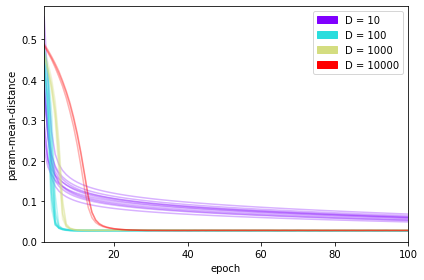

In [18]:
fig, ax = plt.subplots()

plot_regimes_over_ndims(ax, metric='param-mean-distance', logic=ProductLogic(), keepn=50, no_terms=1)
fig.tight_layout()

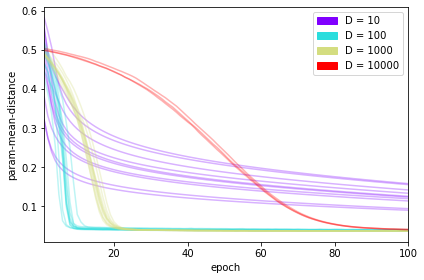

In [22]:
fig, ax = plt.subplots()

plot_regimes_over_ndims(ax, metric='param-mean-distance', logic=ProductLogic(), keepn=50, no_terms=5)

fig.tight_layout()

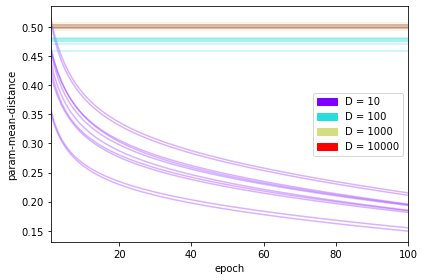

In [19]:
fig, ax = plt.subplots()

plot_regimes_over_ndims(ax, metric='param-mean-distance', logic=ProductLogic(), keepn=50, no_terms=20)

fig.tight_layout()

Fig 2.5

In [ ]:
fig, ax = plt.subplots()

plot_regimes_over_ndims(ax, metric='correct-output', logic=ProductLogic(), keepn=50)

fig.tight_layout()

In [ ]:
fig, ax = plt.subplots()

plot_regimes_over_ndims(ax, metric='correct-param', logic=ProductLogic(), keepn=50)

fig.tight_layout()

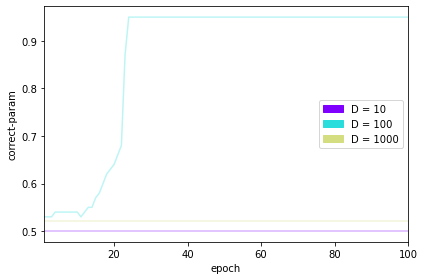

In [26]:
fig, ax = plt.subplots()

plot_regimes_over_ndims(ax, metric='correct-param', logic=ProductLogic(), keepn=None, fix_imbalance=True)

fig.tight_layout()